In [1]:
# which provides functions to interact with the operating system, including file and directory handling.
import os 

import numpy as np 

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [2]:
#Fetch Images count from Fodlers

In [3]:
count = 0 

dirs = os.listdir('flowers/') 
#get a list of all items (files and sub directories) in the 'Images/' directory. In here sub directories only.
#dirs = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
#daisy, dandelion, rose, sunflower, tulip are the sub directories inside the flowers directory.

#The for loop will iterate over each element(sub directories) in the dirs list. Access to the sub directory one by one
for dir in dirs: 
    
    files = list(os.listdir('flowers/'+dir))
    #create a list using files inside sub directory
    #Ex : if dir value is daisy files =['image1.jpg', 'image2.jpg', 'image3.jpg'................................]
    
    print( dir +' Folder has '+ str(len(files)) + ' Images')
    #daisy Folder has 764 Images
    #dandelion Folder has 1052 Images
    #rose Folder has 784 Images
    #sunflower Folder has 733 Images
    #tulip Folder has 984 Images
    
    count = count + len(files)
    
print( 'Images Folder has '+ str(count) + ' Images')
#Images Folder has 4317 Images

daisy Folder has 764 Images
dandelion Folder has 1052 Images
rose Folder has 784 Images
sunflower Folder has 733 Images
tulip Folder has 984 Images
Images Folder has 4317 Images


In [4]:
#Load Images into Arrays as Dataset

In [5]:
base_dir = 'flowers/' #directory where the images are stored
img_size = 180        #each image will be resized to 180x180 pixels. resizing is crucial because neural networks typically require fixed-size inputs
batch = 32            #number of images to be included in each batch during training and validation

In [6]:
#TensorFlow's utility functions to load image data from a directory, split it into training and validation datasets, and prepare it for use in a machine learning model.

In [7]:
#Create the training dataset
#To teach the model how to make predictions
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123, #the same seed value, you ensure that the same images are included in the training and validation datasets each time the code is run
                                                       validation_split=0.2, #splits the data into training and validation sets with a ratio of 80:20.
                                                       subset = 'training', #specifies that this call is for creating the training dataset
                                                       batch_size=batch, #Images are batched into groups of 32
                                                       image_size=(img_size,img_size))

#Create the validation dataset
#To validate the model's performance on data it hasn't seen during training
val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123, #the same seed value, you ensure that the same images are included in the training and validation datasets each time the code is run
                                                       validation_split=0.2, #splits the data into training and validation sets with a ratio of 80:20.
                                                       subset = 'validation', #specifies that this call is for creating the validation dataset
                                                       batch_size=batch, #Images are batched into groups of 32
                                                       image_size=(img_size,img_size))

Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [8]:
flower_names = train_ds.class_names
flower_names

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [9]:
#visualize a batch of images from your training dataset 

In [10]:
#plotting library used for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

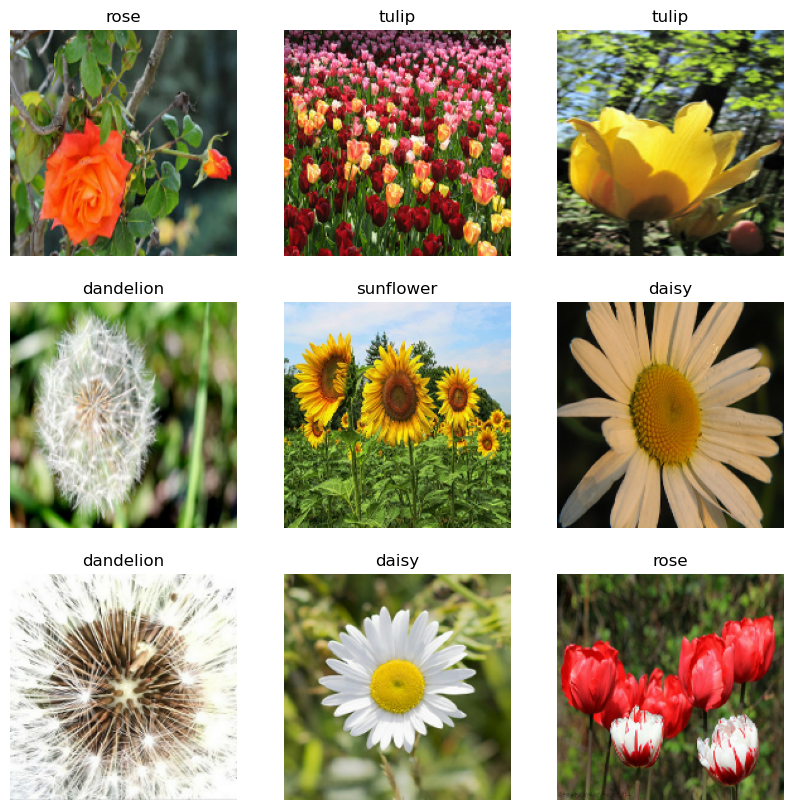

In [11]:
i = 0

#initializes a new figure with a size of 10 inches by 10 inches. This figure will contain all the subplots (individual images)
plt.figure(figsize=(10,10))

#The take(1) method retrieves one batch of images and labels.
for images, labels in train_ds.take(1):
    #inner loop iterates over the first 9 images in the batch
    for i in range(9):
        #creates a grid of subplots that is 3 rows by 3 columns. i + 1 specifies the position of the current subplot.
        plt.subplot(3,3, i+1)
        #displays the image in the subplot.tensors are used to hold data such as images.Converting tensors to NumPy arrays is necessary for compatibility with libraries like matplotlib for visualization
        plt.imshow(images[i].numpy().astype('uint8'))
        # Set the title to the corresponding class name
        plt.title(flower_names[labels[i]])
        # Hide the axis
        plt.axis('off')
        

In [12]:
#optimize the performance of TensorFlow dataset pipelines by leveraging caching, shuffling, and prefetching
#Caching the dataset means that the data will be stored in memory after the first epoch,avoiding the need to re-load and re-process the data from disk
#Shuffling the dataset ensures that the order of the data is randomized,prevent the model from learning any unintended patterns from the order of the data
#Prefetching allows the data to be prepared asynchronously while the model is training,help to reduce idle time for the GPU or CPU and thus improve training performance

In [13]:
#allows TensorFlow to automatically determine the optimal value for certain parameters related to data input pipelines
AUTOTUNE = tf.data.AUTOTUNE

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [15]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [16]:
#Data Augmentation

In [17]:
# Define the data augmentation pipeline
#Increase Training Data Size
#Prevent Overfitting
#Overfitting is a common problem in machine learning and deep learning where a model performs well on training data but fails to generalize to new, unseen data
#Improve Robustness
data_augmentation = Sequential([
    layers.Input(shape=(img_size, img_size, 3)),  # Specify the input shape
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

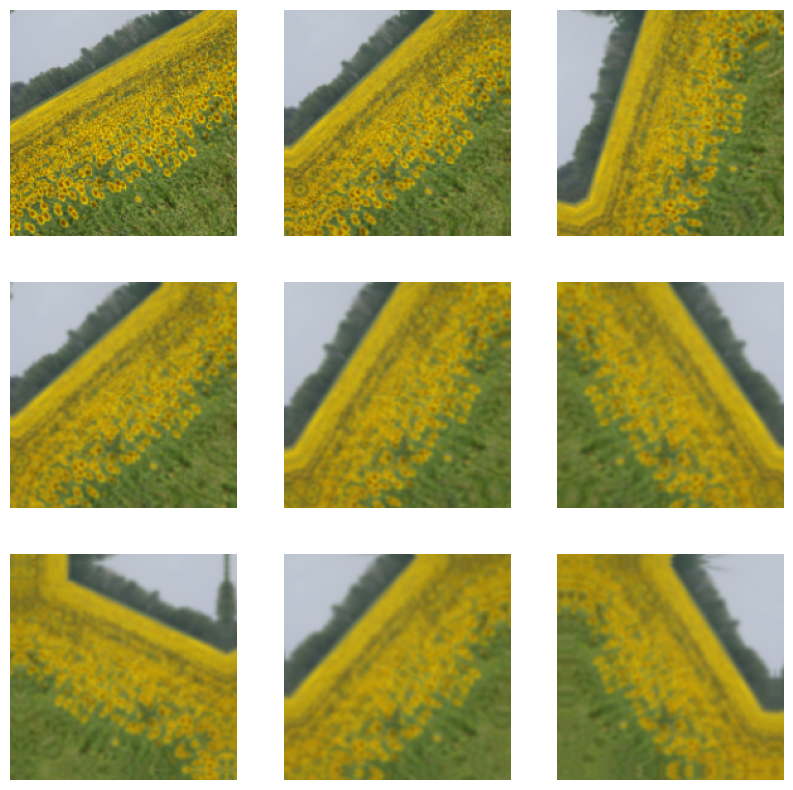

In [18]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [19]:
#Model Creation
#neural networks, a "layer" refers to a collection of neurons that process input data in a specific manner.

In [20]:
model = Sequential([
    #Data Augmentation Layer - Increases training data diversity
    #This layer applies the previously defined data augmentation operations
    data_augmentation,

    #Rescaling Layer - Normalizes the input data.
    #This layer scales the pixel values from the range [0, 255] to the range [0, 1] by dividing by 255.
    layers.Rescaling(1./255),
    
    #Convolutional Layers - Extract spatial features.Applies filters (kernels) across the input to produce feature maps.
    #which helps the network learn more complex patterns
    
    #applies 16 filters of size 3x3 with ReLU activation
    Conv2D(16, 3, padding='same', activation='relu'),
    #retaining the most important features. It also helps reduce computational load and control overfitting.
    MaxPooling2D(),
    
    #applies 32 filters of size 3x3 with ReLU activation
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    #applies 64 filters of size 3x3 with ReLU activation
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    
    #Dropout Layer
    Dropout(0.2),

    #Flatten Layer
    #Converts multi-dimensional arrays into a 1D vector to feed into fully connected layers
    Flatten(),

    #Dense (Fully Connected) Layer
    #Perform classification or regression based on the extracted features.
    Dense(128, activation='relu'),

    # Output Layer
    #Produce the final predictions of the network
    Dense(5)
])

In [21]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 228ms/step - accuracy: 0.3072 - loss: 1.7085 - val_accuracy: 0.5562 - val_loss: 1.0924
Epoch 2/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 218ms/step - accuracy: 0.5719 - loss: 1.0905 - val_accuracy: 0.6269 - val_loss: 0.9593
Epoch 3/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - accuracy: 0.6197 - loss: 0.9803 - val_accuracy: 0.6315 - val_loss: 0.9277
Epoch 4/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.6356 - loss: 0.9204 - val_accuracy: 0.6477 - val_loss: 0.8736
Epoch 5/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.6605 - loss: 0.8503 - val_accuracy: 0.6535 - val_loss: 0.8803
Epoch 6/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 216ms/step - accuracy: 0.6952 - loss: 0.8358 - val_accuracy: 0.6640 - val_loss: 0.8313
Epoch 7/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - accuracy: 0.7083 - loss: 0.7638 - val_accuracy: 0.6732 - val_loss: 0.8950
Epoch 8/15
108/108 ━━━━━━━━━━━━━━━━━━━━ 23s 217ms/step - accuracy: 0.7112 - loss: 0